**IMPORTANDO AS BIBLIOTECAS**

In [161]:
import pandas as pd
import requests
import unidecode
import seaborn as sns
import matplotlib.pyplot as plt

**CARREGANDO OS DADOS**

In [162]:
# Dados de acidentes - Polícia Rodoviária Federal - 2023

data_acidentes = pd.read_csv('acidentes2023_todas_causas_tipos.csv', encoding='latin-1', sep=';')
data_acidentes.head(1)

,id,pesid,data_inversa,dia_semana,horario,uf,br,km,municipio,causa_principal,...,sexo,ilesos,feridos_leves,feridos_graves,mortos,latitude,longitude,regional,delegacia,uop
0,496506,1082142.0,2023-01-01,domingo,00:15:00,MG,116.0,587,MANHUACU,Sim,...,Masculino,0,1,0,0,"-20,24173903","-42,15868042",SPRF-MG,DEL06-MG,UOP03-DEL06-MG


In [163]:
# Dados de estabelecimentos - Governo Federal - 2023

data_estabelecimentos = pd.read_csv('data_estabelecimentos.csv',sep=',')
data_estabelecimentos.head(1)

,codigo_cnes,numero_cnpj_entidade,nome_razao_social,nome_fantasia,natureza_organizacao_entidade,tipo_gestao,descricao_nivel_hierarquia,descricao_esfera_administrativa,codigo_tipo_unidade,codigo_cep_estabelecimento,...,estabelecimento_possui_centro_cirurgico,estabelecimento_possui_centro_obstetrico,estabelecimento_possui_centro_neonatal,estabelecimento_possui_atendimento_hospitalar,estabelecimento_possui_servico_apoio,estabelecimento_possui_atendimento_ambulatorial,codigo_atividade_ensino_unidade,codigo_natureza_organizacao_unidade,codigo_nivel_hierarquia_unidade,codigo_esfera_administrativa_unidade
0,19046,NaN,LABORATORIO SANTA MARIA LTDA SC,LABORATORIO SANTA MARIA,NaN,M,NaN,NaN,39,83005000,...,0.0,0.0,0.0,0.0,1,0,4,NaN,NaN,NaN


In [164]:
# Dados de tipos de unidades - Governo Federal - 2023

data_tipounidades = pd.read_csv('data_tipounidades.csv',sep=',')
data_tipounidades.head(1)

,codigo_tipo_unidade,descricao_tipo_unidade
0,80,LABORATORIO DE SAUDE PUBLICA


In [165]:
# Inserindo as informações dos tipos de unidades nos estabelecimentos.

# Fazendo o merge das tabelas                                                    
data_estabelecimentos_merged = pd.merge(data_estabelecimentos, data_tipounidades, on='codigo_tipo_unidade', how='left')
data_estabelecimentos_merged['descricao_tipo_unidade'].value_counts(normalize= True)

CONSULTORIO ISOLADO                                             0.44880
CLINICA/CENTRO DE ESPECIALIDADE                                 0.19095
CENTRO DE SAUDE/UNIDADE BASICA                                  0.08550
UNIDADE DE APOIO DIAGNOSE E TERAPIA (SADT ISOLADO)              0.07565
FARMACIA                                                        0.05260
POLICLINICA                                                     0.03065
POSTO DE SAUDE                                                  0.01495
UNIDADE MOVEL DE NIVEL PRE-HOSPITALAR NA AREA DE URGENCIA       0.01290
HOSPITAL GERAL                                                  0.01040
CENTRAL DE ABASTECIMENTO                                        0.00905
CENTRAL DE GESTAO EM SAUDE                                      0.00745
POLO ACADEMIA DA SAUDE                                          0.00705
UNIDADE DE VIGILANCIA EM SAUDE                                  0.00585
CENTRO DE ATENCAO PSICOSSOCIAL                                  

**VAMOS CARREGAR BASE DO IBGE (AJUSTADA) CONTENDO O CÓDIGO DOS MUNICÍPIOS.**

In [166]:
CODIGO_MUNICIPIOS = pd.read_csv('base_codigo_municipios.csv',encoding='latin-1',sep=';')

# Transformar os nomes dos municipios para um modo padrão

def transforma_valor(valor):
    valor = unidecode.unidecode(valor)  # Remove acentos
    valor = valor.upper()  # Converte para maiúsculas
    valor = valor.replace('Ç', 'C')  # Substitui Ç por C
    return valor

CODIGO_MUNICIPIOS['municipio'] = CODIGO_MUNICIPIOS['municipio'].apply(transforma_valor)

CODIGO_MUNICIPIOS.head(1)

,CodMun,UF,Cod UF,municipio,codigo_municipio
0,1100015,RO,11,ALTA FLORESTA DOESTE,110001


**INSERINDO NOME DOS MUNICÍPIOS CORRESPONDENTES NA TABELA DOS ESTABELECIMENTOS**

In [167]:
# Fazendo o merge das tabelas                                                    
data_estabelecimentos_merged = pd.merge(data_estabelecimentos_merged, CODIGO_MUNICIPIOS, on='codigo_municipio', how='left')

In [168]:
data_estabelecimentos_merged[['codigo_municipio','municipio']].head()

,codigo_municipio,municipio
0,412550,SAO JOSE DOS PINHAIS
1,420540,FLORIANOPOLIS
2,530010,BRASILIA
3,421930,VIDEIRA
4,410690,CURITIBA


**TRATANDO OS NULOS NOS DATASETS**

In [169]:
# Criando uma cópia do dataframe original dos estabelecimentos
data_unidades = data_estabelecimentos_merged.copy()

In [170]:
# Verificando valores faltantes dos estabelecimentos
data_unidades.isnull().sum()

codigo_cnes                                             0
numero_cnpj_entidade                                16048
nome_razao_social                                       0
nome_fantasia                                           5
natureza_organizacao_entidade                       20000
tipo_gestao                                             0
descricao_nivel_hierarquia                          20000
descricao_esfera_administrativa                     20000
codigo_tipo_unidade                                     0
codigo_cep_estabelecimento                              0
endereco_estabelecimento                                0
numero_estabelecimento                                  6
bairro_estabelecimento                                  1
numero_telefone_estabelecimento                      4971
latitude_estabelecimento_decimo_grau                  188
longitude_estabelecimento_decimo_grau                 185
endereco_email_estabelecimento                       8015
numero_cnpj   

In [171]:
# Filtrando as colunas com mais de 5000 valores faltantes
colunas_nulas = data_unidades.columns[data_unidades.isnull().sum() >= 4000]

# Excluindo essas colunas
data_unidades= data_unidades.drop(columns=colunas_nulas)

# Excluindo linhas nulas não importantes com valores nulos
data_unidades = data_unidades.dropna(subset=['latitude_estabelecimento_decimo_grau'])
data_unidades = data_unidades.dropna(subset=['longitude_estabelecimento_decimo_grau'])

# Preencher com tags de 'Não Identificado'
data_unidades['nome_fantasia'].fillna('Não Identificado', inplace=True)
data_unidades['numero_estabelecimento'].fillna('Não Identificado', inplace=True)
data_unidades['bairro_estabelecimento'].fillna('Não Identificado', inplace=True)

# Restante das colunas terão seus nulos transformados na moda dos seus valores

colunas_preencher_faltantes = ['estabelecimento_possui_centro_cirurgico',
                               'estabelecimento_possui_centro_obstetrico',
                               'estabelecimento_possui_centro_neonatal',
                               'estabelecimento_possui_atendimento_hospitalar',
                              'codigo_identificador_turno_atendimento',
                              'descricao_turno_atendimento']


for coluna in colunas_preencher_faltantes:
    moda = data_unidades[coluna].mode()[0]  # Calcula a moda da coluna
    data_unidades[coluna].fillna(moda, inplace=True)

In [172]:
# Verificando valores faltantes dos acidentes
data_acidentes.isnull().sum()

id                            0
pesid                     19381
data_inversa                  0
dia_semana                    0
horario                       0
uf                            0
br                          565
km                          565
municipio                     0
causa_principal               0
causa_acidente                0
ordem_tipo_acidente           0
tipo_acidente                 0
classificacao_acidente        0
fase_dia                      0
sentido_via                   0
condicao_metereologica        0
tipo_pista                    0
tracado_via                   0
uso_solo                      0
id_veiculo                    0
tipo_veiculo                  0
marca                      9752
ano_fabricacao_veiculo    12530
tipo_envolvido                0
estado_fisico                 0
idade                     44384
sexo                          0
ilesos                        0
feridos_leves                 0
feridos_graves                0
mortos  

In [173]:
# Preenchendo valores faltantes na colunas:
data_acidentes['idade'] = data_acidentes['idade'].fillna(0)
data_acidentes['br'] = data_acidentes['br'].fillna(0)
data_acidentes['km'] = data_acidentes['km'].fillna(0)
data_acidentes['pesid'] = data_acidentes['pesid'].fillna(0)


# Filtrando restante das colunas com valores faltantes
colunas_nulas = data_acidentes.columns[data_acidentes.isnull().sum()>1]

# Excluindo essas colunas
data_acidentes= data_acidentes.drop(columns=colunas_nulas)


**FILTRAR O DATASET DE ACIDENTES PELAS CIDADES PRESENTES EM ESTABELECIMENTOS**

In [174]:
# Criar uma coluna temporária que combina 'municipio' e 'uf' no DataFrame 'data_acidentes'
data_acidentes['municipio_uf'] = data_acidentes['municipio'] + '_' + data_acidentes['uf']

# Relação dos municípios presentes no DataFrame 'data_unidades'
valores_municipio_uf = data_unidades[['municipio', 'UF']].drop_duplicates()

# Criar uma lista de valores de 'municipio_uf' presentes no DataFrame 'valores_municipio_uf'
valores_municipio_uf_lista = valores_municipio_uf.apply(lambda row: f"{row['municipio']}_{row['UF']}", axis=1).tolist()

# Filtrar o DataFrame 'data_acidentes' usando .isin() para a coluna 'municipio_uf'
data_acidentes_filtrado = data_acidentes[data_acidentes['municipio_uf'].isin(valores_municipio_uf_lista)]

# Remover a coluna temporária 'municipio_uf'
data_acidentes_filtrado = data_acidentes_filtrado.drop(columns=['municipio_uf'])


In [175]:
data_acidentes_filtrado.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 191464 entries, 0 to 228948
Data columns (total 32 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   id                      191464 non-null  int64  
 1   pesid                   191464 non-null  float64
 2   data_inversa            191464 non-null  object 
 3   dia_semana              191464 non-null  object 
 4   horario                 191464 non-null  object 
 5   uf                      191464 non-null  object 
 6   br                      191464 non-null  float64
 7   km                      191464 non-null  object 
 8   municipio               191464 non-null  object 
 9   causa_principal         191464 non-null  object 
 10  causa_acidente          191464 non-null  object 
 11  ordem_tipo_acidente     191464 non-null  int64  
 12  tipo_acidente           191464 non-null  object 
 13  classificacao_acidente  191464 non-null  object 
 14  fase_dia            

**SALVANDO DADOS FILTRADOS E TRASNFORMADOS PARA PROCESSAMENTO NO FILE 'calcular_distancias.ipynb'**

In [176]:
data_acidentes_filtrado.to_csv('data_acidentes_filtrado.csv', index = False)
data_unidades.to_csv('data_unidades.csv', index = False)

**CARREGANDO OS DADOS APÓS ADIÇÃO DE CÁLCULO DE DISTÂNCIA DE UNIDADE DE SAÚDE MAIS PRÓXIMA**

In [177]:
data_acidentes_unidades = pd.read_csv('data_acidentes_unidades.csv',sep=',')
data_acidentes_unidades.head(1)

,id,pesid,data_inversa,dia_semana,horario,uf_x,br,km,municipio_x,causa_principal,...,estabelecimento_possui_centro_neonatal,estabelecimento_possui_atendimento_hospitalar,estabelecimento_possui_servico_apoio,estabelecimento_possui_atendimento_ambulatorial,codigo_atividade_ensino_unidade,descricao_tipo_unidade,CodMun,UF,Cod UF,municipio_y
0,496506,1082142.0,2023-01-01,domingo,00:15:00,MG,116.0,587,MANHUACU,Sim,...,0.0,0.0,0,0,4,CONSULTORIO ISOLADO,3139409,MG,31,MANHUACU


**VAMOS SELECIONAR AS VARIÁVEIS MAIS IMPORTANTES PARA NOSSA ANÁLISE**

In [178]:
# Fazendo uma cópia do daframe original
data_final = data_acidentes_unidades.copy()

In [179]:
# Visão geral das colunas
data_final.columns

Index(['id', 'pesid', 'data_inversa', 'dia_semana', 'horario', 'uf_x', 'br',
       'km', 'municipio_x', 'causa_principal', 'causa_acidente',
       'ordem_tipo_acidente', 'tipo_acidente', 'classificacao_acidente',
       'fase_dia', 'sentido_via', 'condicao_metereologica', 'tipo_pista',
       'tracado_via', 'uso_solo', 'id_veiculo', 'tipo_veiculo',
       'tipo_envolvido', 'estado_fisico', 'idade', 'sexo', 'ilesos',
       'feridos_leves', 'feridos_graves', 'mortos', 'latitude', 'longitude',
       'uf_y', 'distancia_minima', 'codigo_cnes', 'lat_unidade_minima',
       'lon_unidade_minima', 'nome_razao_social', 'nome_fantasia',
       'tipo_gestao', 'codigo_tipo_unidade', 'codigo_cep_estabelecimento',
       'endereco_estabelecimento', 'numero_estabelecimento',
       'bairro_estabelecimento', 'latitude_estabelecimento_decimo_grau',
       'longitude_estabelecimento_decimo_grau',
       'codigo_identificador_turno_atendimento', 'descricao_turno_atendimento',
       'estabelecimento_f

In [180]:
# Selecionando colunas
data_final = data_final[['id', 'pesid', 'data_inversa', 'dia_semana', 'horario', 'uf_x',
       'municipio_x', 'causa_principal', 'causa_acidente',
       'ordem_tipo_acidente', 'tipo_acidente', 'classificacao_acidente',
       'fase_dia', 'sentido_via', 'condicao_metereologica', 'tipo_pista',
       'tracado_via', 'uso_solo','tipo_envolvido', 'estado_fisico', 'idade', 'sexo', 'ilesos',
       'feridos_leves', 'feridos_graves', 'mortos', 'latitude', 'longitude',
       'distancia_minima', 'codigo_cnes', 'lat_unidade_minima',
       'lon_unidade_minima', 'nome_razao_social', 'nome_fantasia',
       'tipo_gestao', 'codigo_tipo_unidade',
       'codigo_identificador_turno_atendimento', 'descricao_turno_atendimento',
       'estabelecimento_faz_atendimento_ambulatorial_sus',
       'codigo_estabelecimento_saude', 'codigo_uf', 'codigo_municipio',
       'estabelecimento_possui_centro_cirurgico',
       'estabelecimento_possui_centro_obstetrico',
       'estabelecimento_possui_centro_neonatal',
       'estabelecimento_possui_atendimento_hospitalar',
       'estabelecimento_possui_servico_apoio',
       'estabelecimento_possui_atendimento_ambulatorial',
       'descricao_tipo_unidade']]

**COM A RETIRADA DE ALGUMAS COLUNAS VAMOS REMOVER LINHAS DUPLICADAS**

- Vamos garantir que tenhamos valores únicos para pessoas na base, garantindo uma melhor análise

In [196]:
# Contando as duplicadas
linhas_duplicadas = data_final[data_final.duplicated()]
print(len(linhas_duplicadas))

133


In [182]:
# Removendo duplicadas
data_final = data_final.drop_duplicates()
len(data_final)

179787

**VAMOS FILTRAR ALGUMAS COLUNAS PARA QUE TENHAMOS INFORMAÇÕES DO REALMENTE SERÁ ESTUDADO**

- Vamos analisar apenas a causa principal do acidente. ('causa_principal' = 'Sim)
- Vamos analisar apenas a primeira ordem do acidente. (ordem_tipo_acidente = 1)

In [183]:
data_final['causa_principal'].value_counts()

Sim    102429
Não     77358
Name: causa_principal, dtype: int64

In [184]:
data_final['ordem_tipo_acidente'].value_counts()

1    96013
2    50590
3    24883
4     5485
5     1697
6      721
7      344
8       42
9       12
Name: ordem_tipo_acidente, dtype: int64

In [185]:
# Filtrando colunas
data_final = data_final[data_final['causa_principal'] == 'Sim']
data_final = data_final[data_final['ordem_tipo_acidente'] == 1]

In [197]:
# Removendo duplicadas novamente
data_final = data_final.drop_duplicates()
len(data_final)

58946

**VAMOS AJUSTAR CORRETAMENTE OS TIPOS DOS DADOS**

In [187]:
colunas_numericas = data_final.select_dtypes(include=['number']).columns.tolist()
print(colunas_numericas)

['id', 'pesid', 'ordem_tipo_acidente', 'idade', 'ilesos', 'feridos_leves', 'feridos_graves', 'mortos', 'latitude', 'longitude', 'distancia_minima', 'codigo_cnes', 'lat_unidade_minima', 'lon_unidade_minima', 'codigo_tipo_unidade', 'codigo_identificador_turno_atendimento', 'codigo_estabelecimento_saude', 'codigo_uf', 'codigo_municipio', 'estabelecimento_possui_centro_cirurgico', 'estabelecimento_possui_centro_obstetrico', 'estabelecimento_possui_centro_neonatal', 'estabelecimento_possui_atendimento_hospitalar', 'estabelecimento_possui_servico_apoio', 'estabelecimento_possui_atendimento_ambulatorial']


In [188]:
# Selecionar colunas a serem convertidas
converter_numericas = ['id', 'pesid', 'ordem_tipo_acidente', 'codigo_cnes', 'codigo_tipo_unidade', 'codigo_identificador_turno_atendimento', 
                       'codigo_estabelecimento_saude', 'codigo_uf', 'codigo_municipio'] 

# Converter colunas numéricas em objetos
data_final[converter_numericas] = data_final[converter_numericas].astype(object)

**ANÁLISE DESCRITIVA DOS DADOS**

In [189]:
data_final.describe()

,idade,ilesos,feridos_leves,feridos_graves,mortos,latitude,longitude,distancia_minima,lat_unidade_minima,lon_unidade_minima,estabelecimento_possui_centro_cirurgico,estabelecimento_possui_centro_obstetrico,estabelecimento_possui_centro_neonatal,estabelecimento_possui_atendimento_hospitalar,estabelecimento_possui_servico_apoio,estabelecimento_possui_atendimento_ambulatorial
count,59234.000000,59234.000000,59234.000000,59234.000000,59234.000000,59234.000000,59234.000000,59234.000000,59234.000000,59234.000000,59234.000000,59234.000000,59234.000000,59234.000000,59234.000000,59234.000000
mean,34.574484,0.414644,0.343097,0.105328,0.027822,-19.309609,-46.752997,7.933111,-19.307395,-46.751940,0.014114,0.008661,0.006365,0.015143,0.486950,0.024496
std,36.048229,0.492665,0.474748,0.306978,0.164464,7.609522,6.123810,17.603642,7.615945,6.128091,0.117960,0.092659,0.079525,0.122124,0.499834,0.154585
min,0.000000,0.000000,0.000000,0.000000,0.000000,-33.563259,-68.892258,0.005727,-33.528176,-68.749909,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,0.000000,0.000000,-25.413994,-50.490402,1.505949,-25.418458,-50.519627,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,35.000000,0.000000,0.000000,0.000000,0.000000,-21.008560,-47.676186,3.573875,-21.011000,-47.641193,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,47.000000,1.000000,1.000000,0.000000,0.000000,-14.232185,-42.842918,8.604808,-14.195142,-42.856806,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,2022.000000,1.000000,1.000000,1.000000,1.000000,3.838788,-34.828400,716.666249,3.843000,-34.834000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


**VAMOS TRATAR OS OUTLIERS**
- As idades não identificadas preenchemos com 0 anteriormente - Para análise será necessário filtro
- Colunas de idade e distancia_minima possuem valores e discrepantes e serão excluidos.

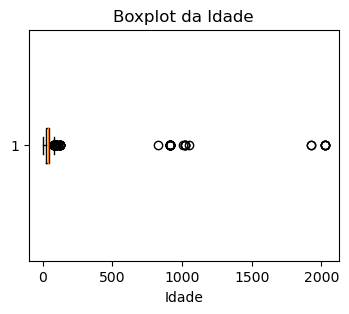

In [190]:
# Criação do boxplot para Idade
plt.figure(figsize=(4, 3))
plt.boxplot(data_final['idade'], vert=False)
plt.title('Boxplot da Idade')
plt.xlabel('Idade')
plt.show()

In [191]:
# Transformar valores maiores que 85 em 0 
data_final.loc[data_final['idade'] > 85]= 0

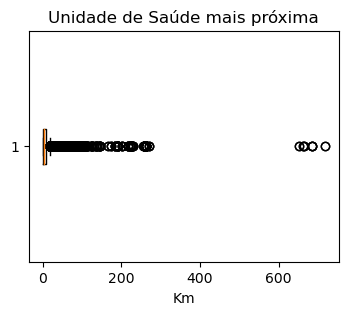

In [192]:
# Criação do boxplot para Idade
plt.figure(figsize=(4, 3))
plt.boxplot(data_final['distancia_minima'], vert=False)
plt.title('Unidade de Saúde mais próxima')
plt.xlabel('Km')
plt.show()

In [205]:
# Excluir valores discrepantes maiores que 120 km
data_final = data_final[data_final['distancia_minima'] <120]

**CRIANDO IDS PARA AS PESSOAS COM IDENTIFICAÇÃO NULA**
- Em etapas anteriores, preenchemos os valores nulos de pesid com 0.
- Como já garantimos que não há duplicatas, podemos inserir um id para cada um
-  Com isso garantimos a unicidade de dados por pessoa envolvida em acidente

In [198]:
# Atribuir valores crescentes começando de 1 para linhas onde pesid é 0
counter = 1
for index, row in data_final.iterrows():
    if row['pesid'] == 0:
        data_final.at[index, 'pesid'] = counter
        counter += 1


In [200]:
print('Total de pesids unicos',len(data_final['pesid'].unique()))
print('Total de linhas na base',len(data_final))

Total de pesids unicos 58946
Total de linhas na base 58946


**VAMOS ANALISAR A CORRELAÇÃO ENTRE AS VARIÁVEIS**

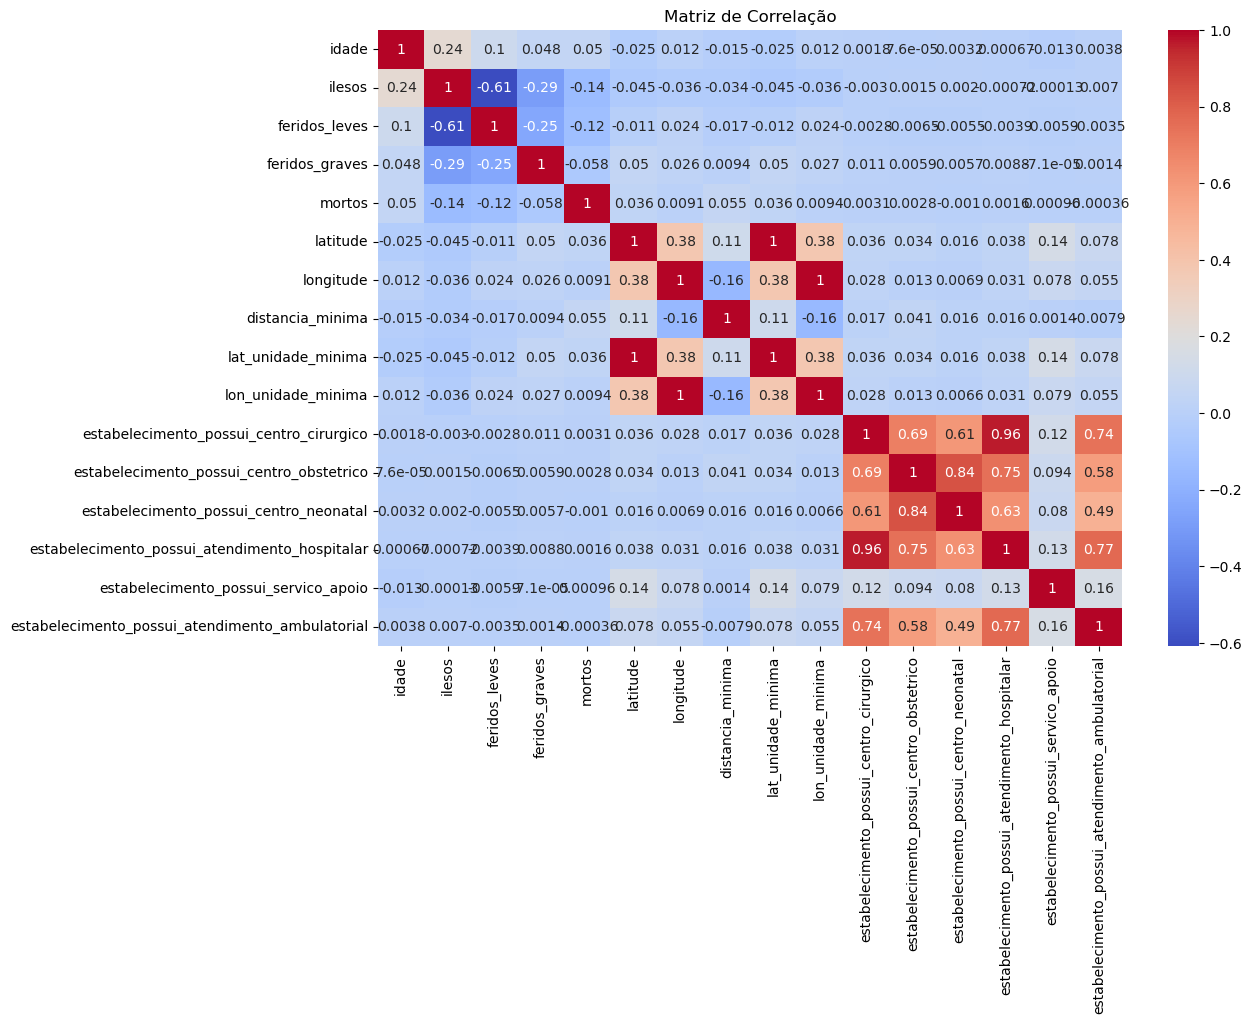

In [204]:
# Calcular a matriz de correlação de Pearson
correlation_matrix = data_final.corr()

# Visualizar a matriz de correlação em um heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Matriz de Correlação')
plt.show()

**SALVANDO DATASET PARA SER INSERIDO NO BANCO DE DADOS E FUTURA ANÁLISE VIA POWERBI**

In [206]:
data_final.to_csv('data_final.csv', index = False)

In [207]:
data_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58946 entries, 2 to 191462
Data columns (total 49 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   id                                                58946 non-null  object 
 1   pesid                                             58946 non-null  object 
 2   data_inversa                                      58946 non-null  object 
 3   dia_semana                                        58946 non-null  object 
 4   horario                                           58946 non-null  object 
 5   uf_x                                              58946 non-null  object 
 6   municipio_x                                       58946 non-null  object 
 7   causa_principal                                   58946 non-null  object 
 8   causa_acidente                                    58946 non-null  object 
 9   ordem_tipo_acide